# Data period features

This notebook characterizes operational and environmental features for each water quality data period.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from bayesian_wq_calibration.simulation import model_simulation
from bayesian_wq_calibration.plotting import plot_network
from bayesian_wq_calibration.constants import TIMESERIES_DIR

Load sensing data for selected data period.

In [2]:
data_period = 2 # 19 calibration events (as at 30 September 2024)

try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
except:
    print(f"Data period {data_period} does not exist.")

### Sensor map

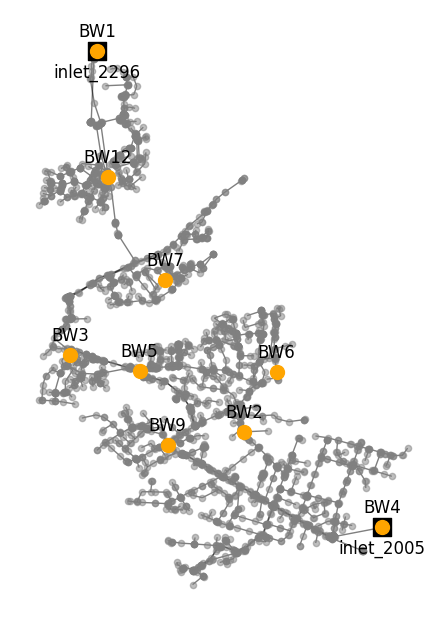

In [3]:
plot_network()

### Time series plot

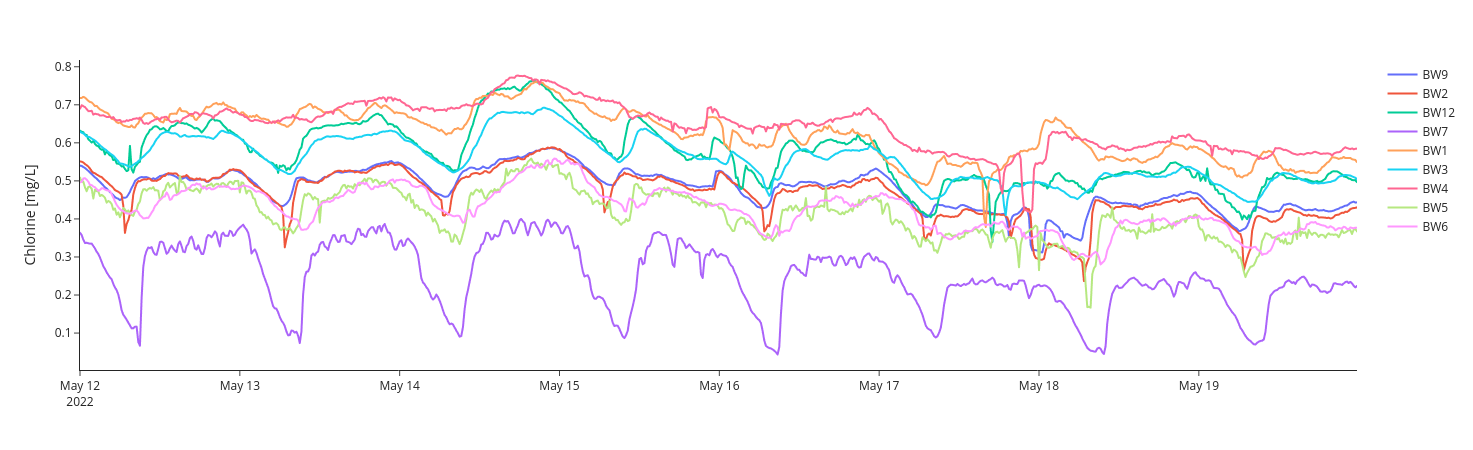

In [8]:
try:
    wq_bwfl_ids = wq_df['bwfl_id'].unique()
    plot_wq_df = wq_df[(wq_df['data_type'] == 'chlorine')]
    fig = px.line(
        plot_wq_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )
    fig.update_layout(
        xaxis_title='',
        yaxis_title='Chlorine [mg/L]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

Missing data summary.

In [5]:
summary_df = (plot_wq_df.groupby('bwfl_id')['mean'].agg(data_percentage=lambda x: int(x.notna().sum() / len(x) * 100)))
display(summary_df)

,data_percentage
bwfl_id,
BW1,100
BW12,100
BW2,100
BW3,100
BW4,100
BW5,100
BW6,100
BW7,100
BW9,100


### Hydraulic conditions

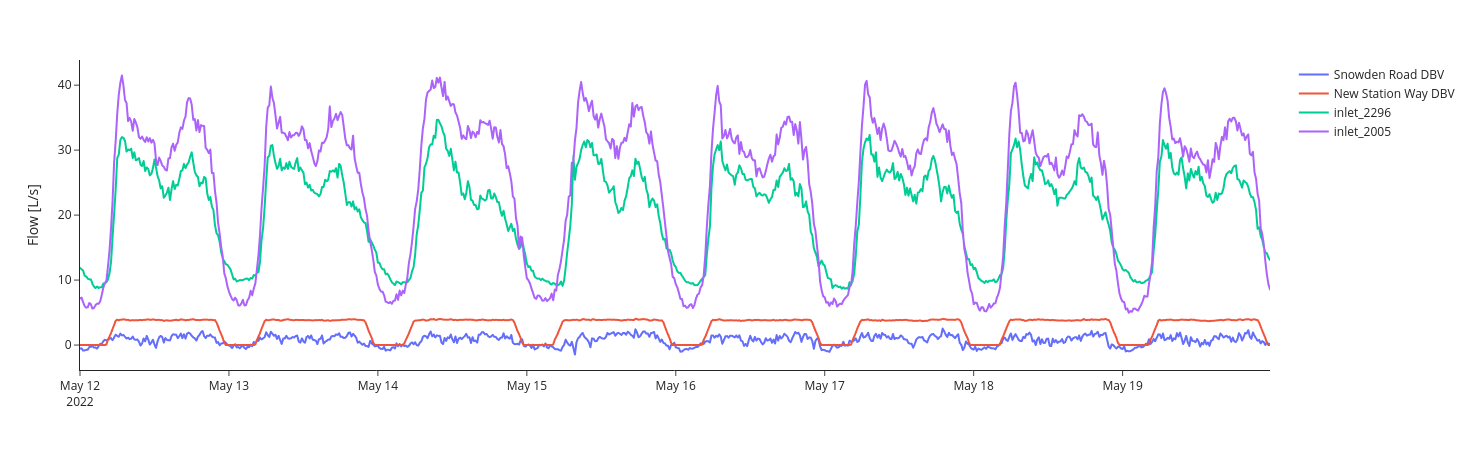

In [6]:
try:
    flow_bwfl_ids = ['inlet_2296', 'inlet_2005', 'Snowden Road DBV', 'New Station Way DBV']
    plot_flow_df = flow_df[flow_df['bwfl_id'].isin(flow_bwfl_ids)]
    fig = px.line(
        plot_flow_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )
    fig.update_layout(
        xaxis_title='',
        yaxis_title='Flow [L/s]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

In [ ]:
# insert box/violin plots showing flow statistics for this period compared to entire dataset

In [7]:
results = model_simulation(flow_df, pressure_df, wq_df, sim_type='age', demand_resolution='wwmd', trace_node='node_2859')

Error setting PRV settings @ link_2820. Default values used.
Error setting PRV settings @ link_2912. Default values used.
